## Temporal difference methods

- Apprend $Q^*$ (ou $V^*$) à partir d'expériences
- Programmation dynamique + Monte Carlo 
- L'agent apprend sur des trajectoires, puis met à jour $Q$ (ou $V$) et la politique
- *Bootstrapping*: l'estimation de l'état $t$ est calculée grâce à l'estimation d'un autre état, $t+1$
- Processus itératif : évaluation + amélioration de la politique


Contrairement à MC, la mise à jour de $Q$ ne s'obtient pas grâce au gain.

Elle peut donc s'effectuer durant un épisode, de manière constante et uniforme.



## SARSA

Dans ce notebook, nous allons implémenter une méthode qui apprend par expérimentation et utilise le *bootstrapping*.
Elle s'appelle SARSA à cause des éléments qu'elle utilise pour la mise à jour:

\begin{equation}
\text{S}_t, \text{A}_t, \text{R}_t, \text{S}_{t+1}, \text{A}_{t+1}
\end{equation}
    
Cette une méthode qui suit une stratégie *on-policy*, dans laquelle la politique optimisée est aussi responsable de parcourir l'environnement.

## Gérer les imports

In [1]:
import gym
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython import display

from bucket_env import BucketEnv3
from bucket_env import plot_stats, testing, rendering
%matplotlib inline

pygame 2.1.4.dev1 (SDL 2.26.0, Python 3.11.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


objc[69918]: Class SDLApplication is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x1105087c0) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x120588800). One of the two will be used. Which one is undefined.
objc[69918]: Class SDLAppDelegate is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x110508810) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x120588850). One of the two will be used. Which one is undefined.
objc[69918]: Class SDLTranslatorResponder is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x110508888) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x1205888c8). One of the two will be used. Which one is undefined.
objc[69918]: Class SDLMessageBoxPresenter is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x1105088b0) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x1205888f0). One of the two will be used. Which one is undefined.
objc[69918]: Class SDL_cocoametalview is imp

## Initialiser l'environnement
Pour créer l'environnement, il faut simplement créer une instance de `PalletEnv`

In [2]:
env = BucketEnv3()

## Definition de la table de valeurs $Q(s, a)$

#### Création de la table $Q(s, a)$
Cette table doit permettre de lier chaque état à une action.
Pour cela, on utilise la librairie `numpy` pour créer un tableau avec une forme (*shape*) correspondant à cette paire.
La forme attendu est donnée par un tuple.

Exemple
```python
>>> s = (2,2)
>>> np.zeros(s)
array([[ 0.,  0.],
       [ 0.,  0.]])
```


In [21]:
action_values = np.zeros((7,7,7,5))

## Définition d'une politique $\pi(s)$

#### Création de la politique $\pi(s)$
La politique indique l'action à prendre en fonction d'un état.
Cette politique étant $\epsilon-$greedy, elle responsable de l'exploration de l'espace.
Elle devra donc parfois renvoyer une action aléatoire.
Pour cela, nous allons définir une fonction prenant en paramètre une état et un paramètre `epsilon` ayant comme valeur par défaut `0.2`, indiquant que 20% du temps, une action aléatoire sera prise.

La prise en compte d'epsilon se fera en la comparant avec une valeur prise aléatoirement, grâce à `np.random.random()`.
La décision aléatoire sera également prise aléatoirement parmi les 5 actions possibles, grâce à `np.random.choice(5)`.
Dans le cas où la décision est prise par rapport $Q(s,a)$, il faut choisir l'action qui maximise la probabilité de succès. Comme il peut y avoir plusieurs actions maximisant cette valeur, nous allons devoir casser les équivalences. Pour cela, nous allons utiliser `np.flatnonzero()` combiné à la condition de maximisation `a == a.max()`

In [32]:
def policy(state, epsilon=.1):
    if np.random.random() < epsilon:
        return np.random.choice(5)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

#### Tester la politique avec l'état (0, 0, 0)

In [23]:
policy(env.reset())

1

## Implementation de l'algorithme

</br>

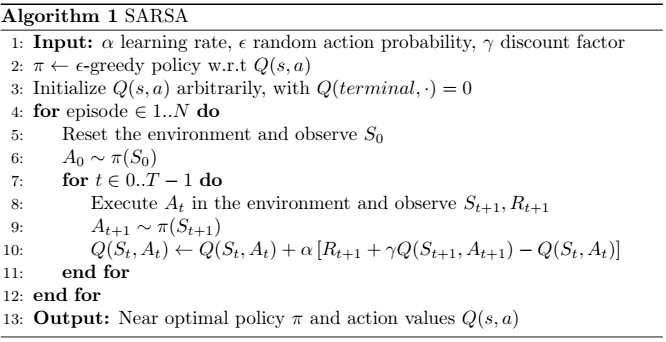
</br>
<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>



In [33]:
def sarsa(policy, action_values, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {"Returns":[]}
    for episode in tqdm(range(1, episodes+1)):
        state = env.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done :
            next_state, reward, done, _ = env.step(action)
            # mise à jour de Q
            next_action = policy(next_state) if not done else None
            
            # maj state_values
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action] if not done else 0.
            
            #ligne 10
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)

            state = next_state
            ep_return += reward
        stats["Returns"].append(ep_return)
    return stats


In [37]:
action_values = np.zeros((7,7,7,5))
stats = sarsa(policy,action_values,episodes=100, epsilon=0.05)

100%|██████████| 100/100 [00:00<00:00, 16067.05it/s]


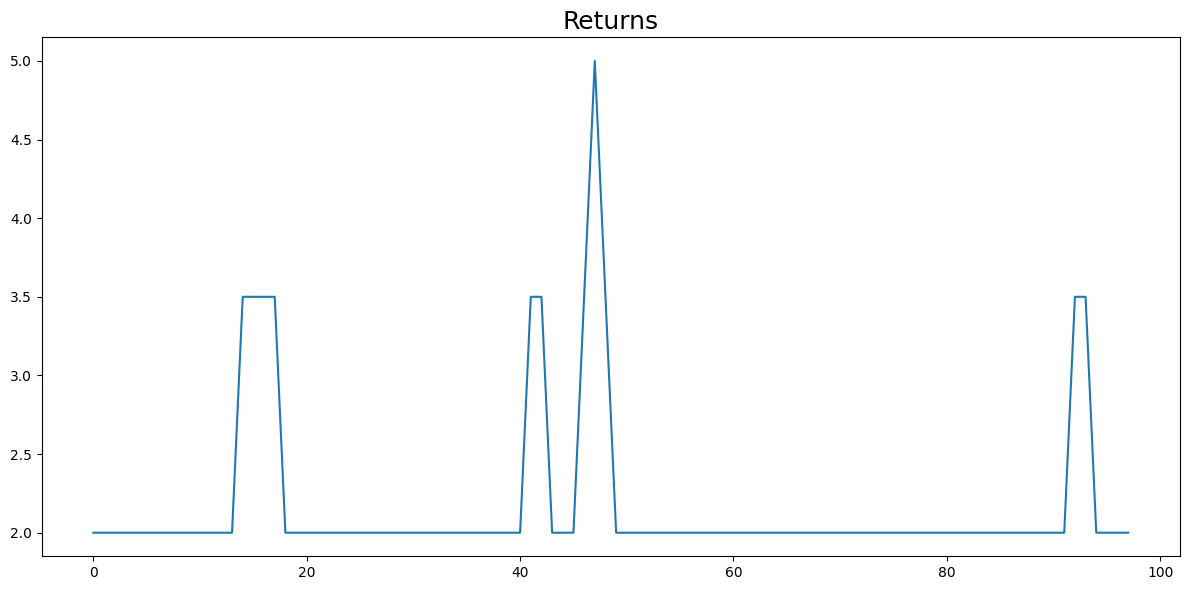

In [38]:
plot_stats(stats,smooth=1)